# CTIP1 vs. Attendance Area Overlap Analysis

Analyzes the spatial overlap between SFUSD elementary school attendance areas and CTIP1 (Census Tract Integration Preference 1) priority zones.

**Data sources:**
- SFUSD elementary attendance area boundaries from [SF Open Data](https://data.sfgov.org/resource/e6tr-sxwg.geojson)
- Census 2020 tract boundaries from [SF Open Data](https://data.sfgov.org/resource/tmph-tgz9.geojson)
- CTIP1 status per tract from [Datawrapper dataset](https://datawrapper.dwcdn.net/9fX5e/2/dataset.csv)

In [1]:
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import contextily as cx
import io
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

## 1. Load Geospatial Data

In [2]:
# Load SFUSD elementary attendance areas
# geopandas doesn't handle $limit query params well, so download with requests first
aa_resp = requests.get("https://data.sfgov.org/resource/e6tr-sxwg.geojson", params={"$limit": 9999})
attendance_areas = gpd.read_file(io.BytesIO(aa_resp.content))
attendance_areas = attendance_areas[attendance_areas['e_aa_name'].notna()].copy()
if attendance_areas.crs is None:
    attendance_areas.set_crs(epsg=4326, inplace=True)
print(f"Loaded {len(attendance_areas)} elementary attendance areas")
attendance_areas[['e_aa_name', 'e_aa_schno']].head()

Loaded 58 elementary attendance areas


,e_aa_name,e_aa_schno
0,DREW,507.0
1,TAYLOR,513.0
2,HARTE,453.0
3,EL DORADO,521.0
4,HILLCREST,614.0


In [3]:
# Load Census 2020 tracts for San Francisco
tracts_resp = requests.get("https://data.sfgov.org/resource/tmph-tgz9.geojson", params={"$limit": 9999})
tracts = gpd.read_file(io.BytesIO(tracts_resp.content))
if tracts.crs is None:
    tracts.set_crs(epsg=4326, inplace=True)
print(f"Loaded {len(tracts)} census tracts")
tracts[['geoid', 'name', 'tractce']].head()

Loaded 244 census tracts


,geoid,name,tractce
0,06075980501,9805.01,980501
1,06075017102,171.02,017102
2,06075012302,123.02,012302
3,06075016801,168.01,016801
4,06075011902,119.02,011902


## 2. Load CTIP1 Status per Census Tract

CTIP1 (Census Tract Integration Preference 1) designates census tracts with the lowest average test scores. Students living in CTIP1 tracts receive enrollment priority.

In [4]:
# Load CTIP1 data
ctip_resp = requests.get("https://datawrapper.dwcdn.net/9fX5e/2/dataset.csv")
ctip_df = pd.read_csv(io.StringIO(ctip_resp.text), dtype={'TRACTCE': str})

# Zero-pad TRACTCE to 6 characters to match SF Open Data format
ctip_df['TRACTCE'] = ctip_df['TRACTCE'].str.zfill(6)

print(f"Loaded CTIP status for {len(ctip_df)} tracts")
print(f"CTIP1=TRUE: {(ctip_df['CTIP1'] == True).sum()}")
print(f"CTIP1=FALSE: {(ctip_df['CTIP1'] == False).sum()}")

# Merge onto tract geometries using tractce field
tracts_with_ctip = tracts.merge(ctip_df, left_on='tractce', right_on='TRACTCE', how='left')
ctip1_tracts = tracts_with_ctip[tracts_with_ctip['CTIP1'] == True].copy()
non_ctip1_tracts = tracts_with_ctip[tracts_with_ctip['CTIP1'] == False].copy()
unmatched = tracts_with_ctip[tracts_with_ctip['CTIP1'].isna()]

print(f"\nMatched to geometries:")
print(f"  CTIP1 tracts: {len(ctip1_tracts)}")
print(f"  Non-CTIP1 tracts: {len(non_ctip1_tracts)}")
if len(unmatched) > 0:
    print(f"  Unmatched tracts: {len(unmatched)} ({', '.join(unmatched['name'].tolist())})")

Loaded CTIP status for 242 tracts
CTIP1=TRUE: 34
CTIP1=FALSE: 208

Matched to geometries:
  CTIP1 tracts: 34
  Non-CTIP1 tracts: 208
  Unmatched tracts: 2 (9804.01, 9901)


## 3. Spatial Overlay Analysis

In [5]:
# Project to a meter-based CRS for area calculations (CA State Plane Zone 3, feet)
proj_crs = 'EPSG:2227'
aa_proj = attendance_areas.to_crs(proj_crs)
ctip1_proj = ctip1_tracts.to_crs(proj_crs)

# Dissolve CTIP1 tracts into a single zone
ctip1_zone = ctip1_proj.dissolve()
ctip1_total_area = ctip1_zone.geometry.area.iloc[0]
print(f"Total CTIP1 area: {ctip1_total_area / 43560:,.0f} acres")

Total CTIP1 area: 5,887 acres


In [7]:
# Compute intersection of each attendance area with the CTIP1 zone
results = []
for _, aa in aa_proj.iterrows():
    aa_name = aa['e_aa_name']
    aa_area = aa.geometry.area
    
    intersection = aa.geometry.intersection(ctip1_zone.geometry.iloc[0])
    intersection_area = intersection.area
    
    pct_aa_in_ctip1 = (intersection_area / aa_area * 100) if aa_area > 0 else 0
    pct_ctip1_in_aa = (intersection_area / ctip1_total_area * 100) if ctip1_total_area > 0 else 0
    
    results.append({
        'attendance_area': aa_name,
        'aa_area_acres': aa_area / 43560,
        'overlap_area_acres': intersection_area / 43560,
        'pct_aa_in_ctip1': pct_aa_in_ctip1,
        'pct_ctip1_in_aa': pct_ctip1_in_aa,
    })

overlap_df = pd.DataFrame(results).sort_values('pct_aa_in_ctip1', ascending=False)
overlap_df.to_csv('ctip_aa_overlap.csv', index=False)
print(f"Saved overlap results to ctip_aa_overlap.csv")
overlap_df.sort_values( 'attendance_area' ).round(1)

Saved overlap results to ctip_aa_overlap.csv


,attendance_area,aa_area_acres,overlap_area_acres,pct_aa_in_ctip1,pct_ctip1_in_aa
31,ALAMO,971.0,0.0,0.0,0.0
12,ALVARADO,498.8,12.8,2.6,0.2
29,ARGONNE,342.9,0.0,0.0,0.0
30,BRYANT,191.3,114.0,59.6,1.9
6,CARVER,732.2,732.2,100.0,12.4
38,CHAVEZ,169.4,151.3,89.3,2.6
16,CHIN,568.5,273.6,48.1,4.6
36,CLARENDON,1004.2,0.0,0.0,0.0
54,CLEVELAND,294.5,0.5,0.2,0.0
35,COBB,539.3,1.4,0.3,0.0


## 4. Visualization

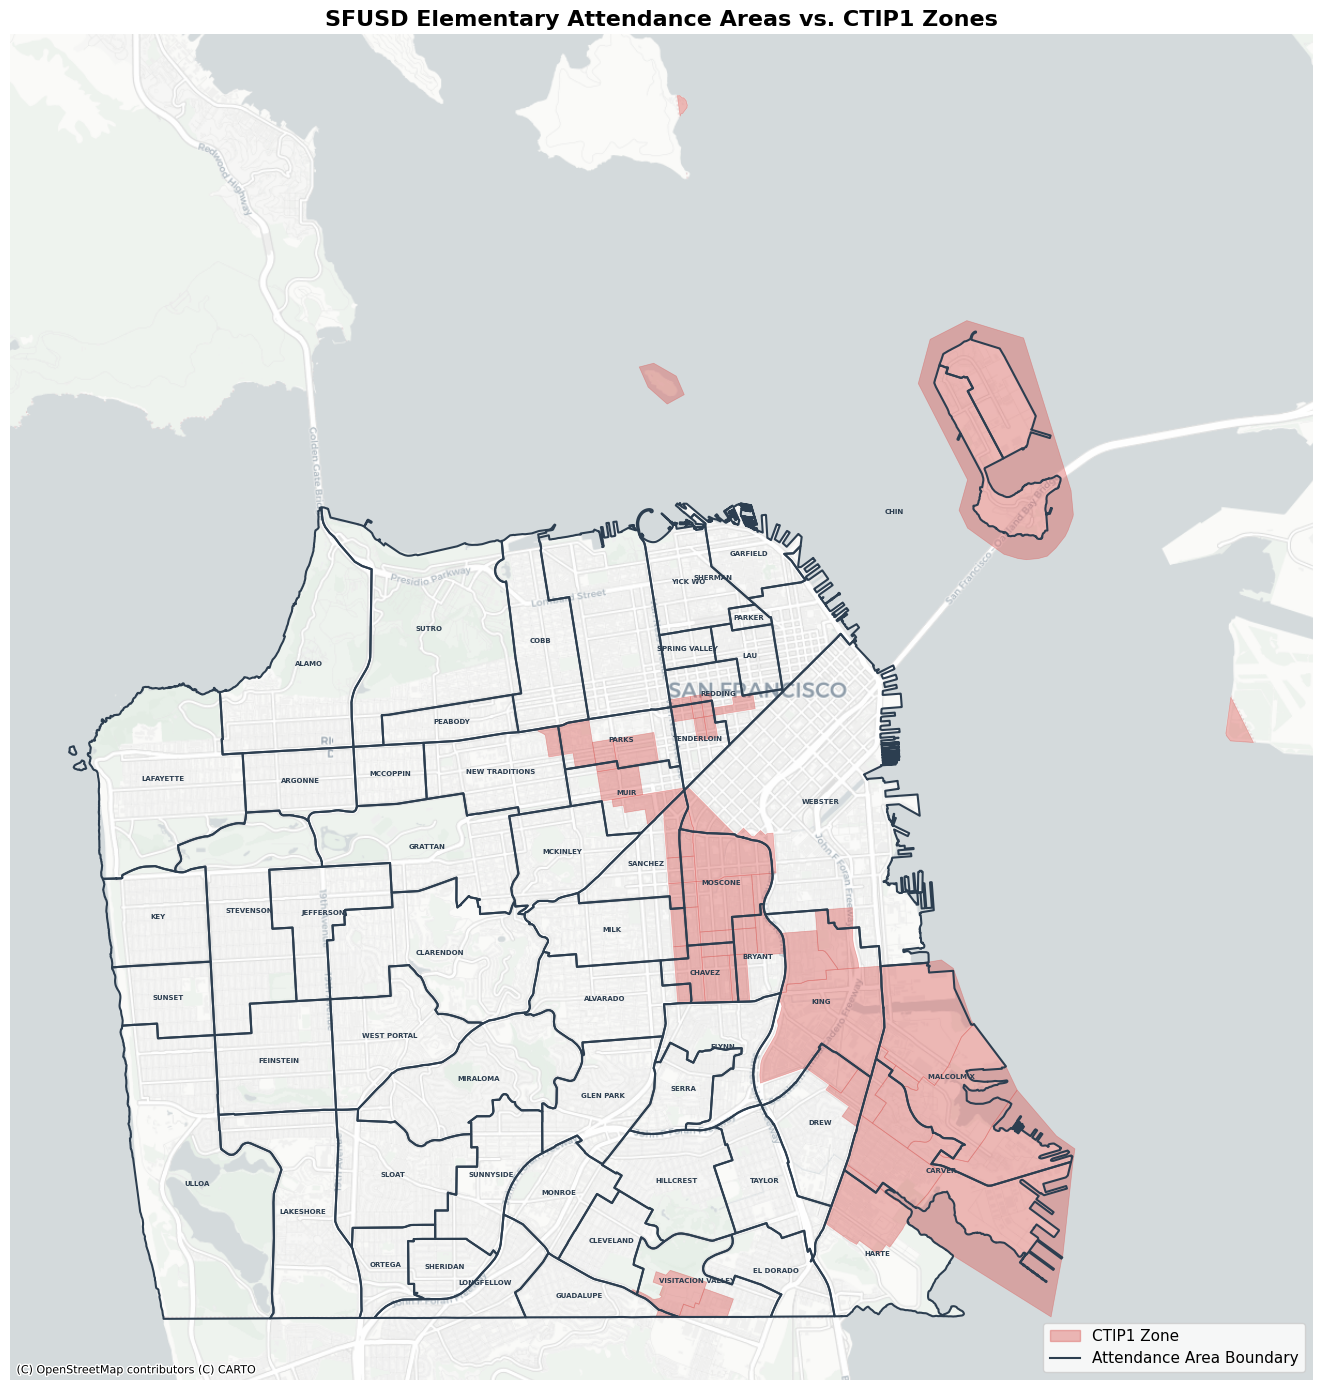

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Plot in Web Mercator for contextily basemap
web_mercator = 'EPSG:3857'
aa_wm = attendance_areas.to_crs(web_mercator)
ctip1_wm = ctip1_tracts.to_crs(web_mercator)

# CTIP1 tracts (shaded red)
ctip1_wm.plot(ax=ax, color='#d9534f', alpha=0.4, edgecolor='#d9534f', linewidth=0.5)

# Attendance area boundaries (thick blue outlines)
aa_wm.plot(ax=ax, facecolor='none', edgecolor='#2c3e50', linewidth=1.5)

# Label attendance areas
for _, row in aa_wm.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(
        row['e_aa_name'],
        xy=(centroid.x, centroid.y),
        fontsize=5,
        ha='center',
        va='center',
        fontweight='bold',
        color='#2c3e50',
    )

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=13)

ax.set_title('SFUSD Elementary Attendance Areas vs. CTIP1 Zones', fontsize=16, fontweight='bold')
ax.set_axis_off()

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#d9534f', alpha=0.4, edgecolor='#d9534f', label='CTIP1 Zone'),
    Line2D([0], [0], color='#2c3e50', linewidth=1.5, label='Attendance Area Boundary'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('ctip_aa_map.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary Statistics

In [9]:
total_sf_area = aa_proj.geometry.area.sum()

print("=" * 70)
print("CTIP1 vs ATTENDANCE AREA OVERLAP SUMMARY")
print("=" * 70)

print(f"\nTotal CTIP1 area: {ctip1_total_area / 43560:,.0f} acres")
print(f"Total attendance area coverage: {total_sf_area / 43560:,.0f} acres")
print(f"CTIP1 as % of total: {ctip1_total_area / total_sf_area * 100:.1f}%")

print(f"\n--- Attendance Areas with >50% CTIP1 overlap ---")
high_overlap = overlap_df[overlap_df['pct_aa_in_ctip1'] > 50]
print(f"Count: {len(high_overlap)}")
if len(high_overlap) > 0:
    print(high_overlap[['attendance_area', 'pct_aa_in_ctip1']].to_string(index=False))

print(f"\n--- Attendance Areas with >0% but <=50% CTIP1 overlap ---")
partial_overlap = overlap_df[(overlap_df['pct_aa_in_ctip1'] > 0) & (overlap_df['pct_aa_in_ctip1'] <= 50)]
print(f"Count: {len(partial_overlap)}")
if len(partial_overlap) > 0:
    print(partial_overlap[['attendance_area', 'pct_aa_in_ctip1']].to_string(index=False))

print(f"\n--- Attendance Areas with 0% CTIP1 overlap ---")
no_overlap = overlap_df[overlap_df['pct_aa_in_ctip1'] == 0]
print(f"Count: {len(no_overlap)}")
if len(no_overlap) > 0:
    print(', '.join(no_overlap['attendance_area'].tolist()))

print(f"\n--- Full ranking by CTIP1 overlap % ---")
print(overlap_df[['attendance_area', 'pct_aa_in_ctip1', 'pct_ctip1_in_aa']]
      .rename(columns={'pct_aa_in_ctip1': '% of AA in CTIP1', 'pct_ctip1_in_aa': '% of CTIP1 in AA'})
      .to_string(index=False))

CTIP1 vs ATTENDANCE AREA OVERLAP SUMMARY

Total CTIP1 area: 5,887 acres
Total attendance area coverage: 30,336 acres
CTIP1 as % of total: 19.4%

--- Attendance Areas with >50% CTIP1 overlap ---
Count: 7
attendance_area  pct_aa_in_ctip1
         CARVER       100.000000
        MOSCONE        99.998743
      MALCOLM X        99.997916
         CHAVEZ        89.334411
           KING        82.511316
         BRYANT        59.583187
          PARKS        51.773122

--- Attendance Areas with >0% but <=50% CTIP1 overlap ---
Count: 19
  attendance_area  pct_aa_in_ctip1
             CHIN        48.137430
             MUIR        41.968032
       TENDERLOIN        34.283475
VISITACION VALLEY        33.387834
            HARTE        32.095049
          SANCHEZ        28.824241
          SHERMAN        26.794400
             DREW        24.518530
          REDDING        17.377072
             MILK         7.766865
          WEBSTER         4.856480
   NEW TRADITIONS         4.399938
         